In [1]:
from align_spheroid import CellSimulator, Aligner2D
from align_spheroid.evaluation import (
    compare_paths, procrustes_distance, hausdorff_distance, earth_movers_distance, 
    frechet_distance, relative_movement, normalize_distance, distance_matrix_error,
    alignment_accuracy, build_long_true, calc_accuracy
)
from align_spheroid.alignment import convert_raw_to_long
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Example of Spheroid Matching and Alignment Algorithm

## Generate Simulated Data

In [2]:
# Simulation parameters
timepoints = ["0h", "24h", "48h", "72h", "168h"]
n_circles = 6
width = 1000
height = 1000

# create a random number generator instance for consistent seeding
rng = np.random.default_rng(seed = 2025)

# Define rotations, translations, and individual movements for each time point
rotations = [rng.uniform(0, 360) for _ in range(len(timepoints) - 1)]
translations = [(rng.integers(0, 50), rng.integers(0, 50)) for _ in range(len(timepoints) - 1)]

# Example: Move cell 'a' 10% of its radius or distance to nearest neighbor at each time point
# individual movement given by a list of dictionaries with point labels as keys and 
# percentage movement by values
# the total number of dictionaries should match the total number of time steps to perturb
individual_movements = [
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03},  
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03}, 
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03}, 
    {'a': 0.01, 'b':0.05, 'c': 0.05, 'd': 0.02, 'e': 0.06, 'f':0.03},
] 

# Create a simulator instance
simulator = CellSimulator(n_circles=n_circles, width=width, height=height, rng=rng)

# Run the simulation
simulated_data = simulator.simulate(
    time_points=timepoints, 
    rotations=rotations, 
    translations=translations, 
    individual_movements=individual_movements,
    mvmnt_type='min'
)

# prep the data for matching algorithm
dataX = simulated_data[[col for col in simulated_data.columns if 'x' in col]].values 
dataY = simulated_data[[col for col in simulated_data.columns if 'y' in col]].values 

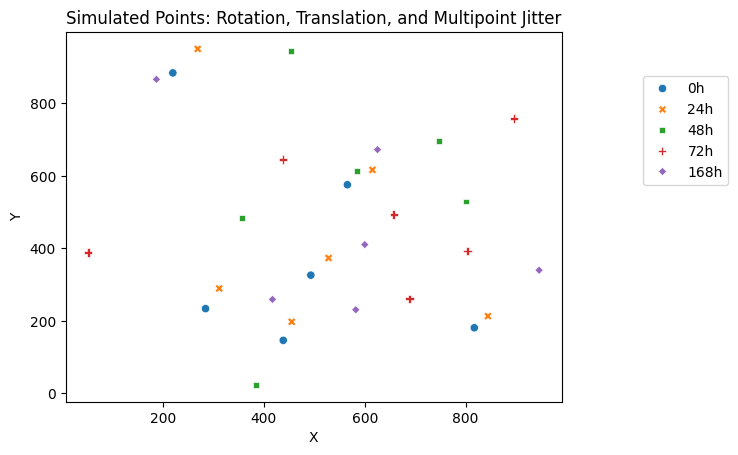

In [4]:
simulated_data_long = convert_raw_to_long(simulated_data, point_name='label')

# Plot all points in the "well"
fig = plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    data = simulated_data_long,
    x = 'raw_x',
    y = 'raw_y',
    hue = 'Timepoint', #'Original Point Name', 
    style = 'Timepoint',
    ax=ax
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Simulated Points: Rotation, Translation, and Multipoint Jitter')
leg = ax.legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))
plt.show()
plt.close()

## Running the Matching Algorithm

In [5]:
# Create an Aligner2D instance
aligner = Aligner2D(well_name="Example Simulation", time_points=timepoints)

# get the labels to use for the alignment
labels = list(simulated_data.label)

# Align the data (well_id 0 is just an example)
aligner = aligner.align(dataX, dataY, labels_0=labels)

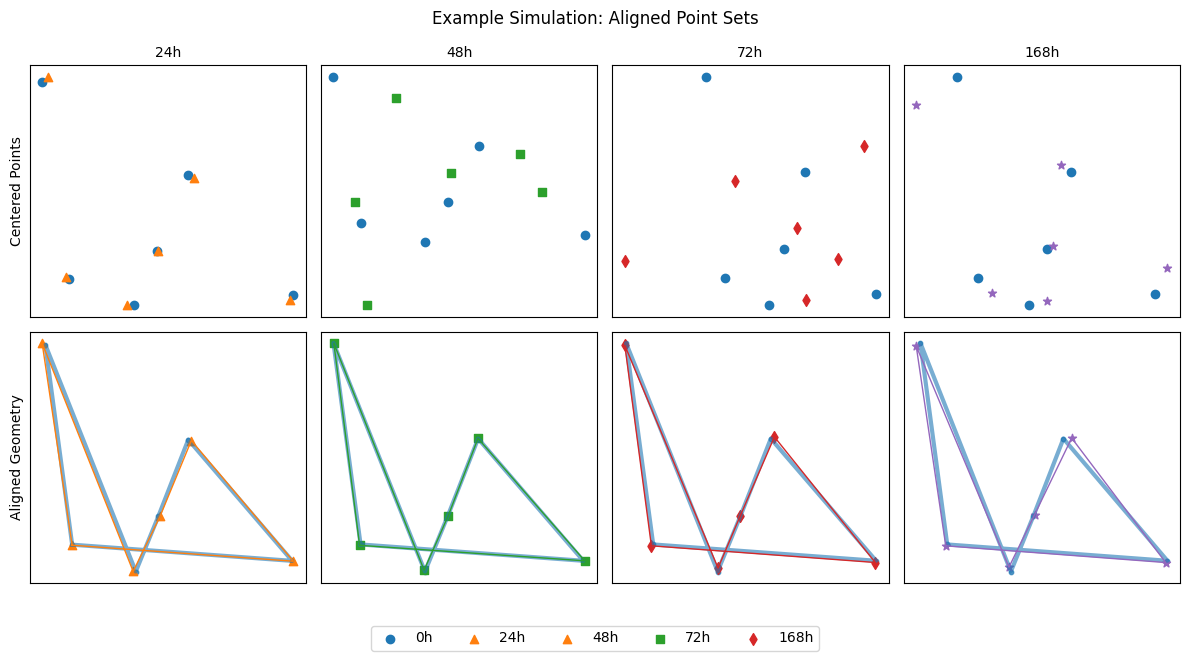

<Figure size 640x480 with 0 Axes>

In [6]:
# plotting
fig, axs = plt.subplots(2, len(timepoints) - 1, figsize=(12, 6))  # Adjust figsize as needed
aligner.plot(fig=fig, axs=axs, show_plot=True)  # Pass fig and axs
plt.tight_layout()
plt.show()
plt.close()

## Before and After Matching Plot

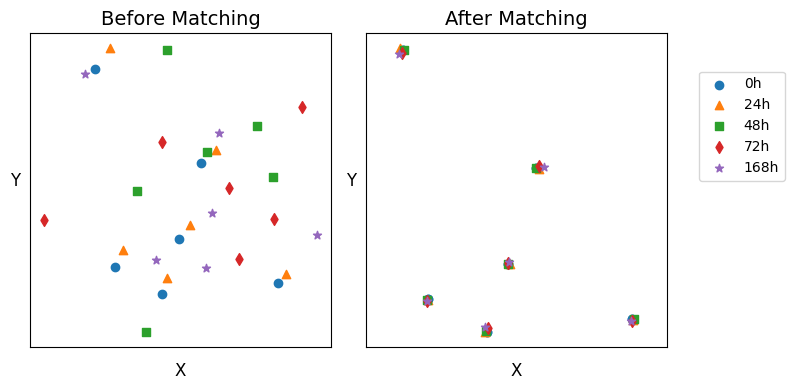

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.ravel()

title_fs = 14
label_fs = 12

marker_shape = ['o', '^', 's', 'd', '*']

for t, tp in enumerate(timepoints):
    tp_data = simulated_data_long[simulated_data_long['Timepoint'] == tp]
    ax[0].scatter(
        tp_data['raw_x'],
        tp_data['raw_y'],
        marker=marker_shape[t]
    )
# before alignment
ax[0].set_xlabel('X', fontsize=label_fs)
ax[0].set_ylabel('Y', fontsize=label_fs, rotation=0)
ax[0].set_title('Before Matching', fontsize=title_fs)
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].tick_params(
    which='both',
    bottom=False,
    left=False
)
ax[0].axis('equal')

t0_pts = pd.DataFrame(aligner.centeredA, columns = ['registered_x', 'registered_y'])
t0_pts['timepoint'] = '0h'

df = pd.concat([
    t0_pts,
    aligner.registered_df[['registered_x', 'registered_y', 'timepoint']]
], axis=0)

# after alignment
for t, tp in enumerate(timepoints):
    tp_data = df[df['timepoint'] == tp]
    ax[1].scatter(
        tp_data['registered_x'],
        tp_data['registered_y'],
        marker=marker_shape[t],
        label=tp
    )

ax[1].set_xlabel('X', fontsize=label_fs)
ax[1].set_ylabel('Y', fontsize=label_fs, rotation=0)
ax[1].set_title('After Matching', fontsize=title_fs)
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].tick_params(
    which='both',
    bottom=False,
    left=False
)
ax[1].axis('equal')


labels = timepoints
#colors = 
leg = ax[1].legend(loc="upper center", bbox_to_anchor=(1.0, 0.4, 0.5, 0.5))

plt.tight_layout()
plt.show()
plt.close()